# Public Archive

This code is no longer maintained. There may be dependency issues/code been updated since.

## DEEP PLASTIC.


In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)# We need to install the correct cuDNN according to this output

In [ ]:
#take a look at the kind of GPU we have
!nvidia-smi

# Step 2: Cloning and Building Darknet
The following cells will clone darknet from AlexeyAB's famous repository, adjust the Makefile to enable OPENCV and GPU for darknet and then build darknet.

Do not worry about any warnings when you run the '!make' cell!

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

In [ ]:
# define helper functions

# Helper functions to display image, download and upload images from/to colab
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
# Important Step : Mount Google Drive to have access to dataset/weights/config etc
# Rename google drive to mydrive to make it easier to access
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
%cd /content/darknet
!curl -L "https://app.roboflow.com/ds/vY7bjzh1VL?key=ORR0zx7SjM" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# Step 3: Configuring Files for Training
This step involves properly configuring your custom .cfg, obj.data, obj.names, train.txt and test.txt files.

It is important to configure all these files with extreme caution as typos or small errors can cause major problems with your custom training.

Copy Config file to Gdrive to Edit.

### Commented out for now since we have our final config file. Copying will alter that file back to new state (Careful)

In [ ]:
# download cfg to google drive and change its name
#cp cfg/yolov4-custom.cfg /mydrive/yolov4/yolov4-obj.cfg

In [ ]:
# to download to local machine (change its name to yolov4-obj.cfg once you download)
#download('cfg/yolov4-custom.cfg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Set up training file directories for custom dataset
%cd /content/darknet/
%cp train/_darknet.labels data/obj.names
%mkdir data/obj
#copy image and labels
%cp train/*.jpg data/obj/
%cp valid/*.jpg data/obj/

%cp train/*.txt data/obj/
%cp valid/*.txt data/obj/

with open('data/obj.data', 'w') as out:
  out.write('classes = 1\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

#write train file (just the image list)
import os

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir('train') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
import os

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir('valid') if f.endswith('jpg')]:
    out.write('data/obj/' + img + '\n')

/content/darknet


In [ ]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_darknet.labels')
max_batches = 100
steps1 = .8 * max_batches
steps2 = .9 * max_batches
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3


print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')


#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

  



writing config for a custom YOLOv4 detector detecting number of classes: 1


In [ ]:
%%writetemplate ./cfg/custom-yolov4-tiny-detector.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=24
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.0055
burn_in=1000
max_batches =10000
policy=steps
steps={steps_str}
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

In [ ]:
%cat cfg/custom-yolov4-tiny-detector.cfg

In [ ]:
# Confirm that our text files have been made in the Data folder.
!ls data/

In [ ]:
# Downloading the YOLO v4 pretrained weights for Convolutions from AlexeyAB's Github.
# NOTE: You have pretrained Weights with 70% MaP. Use those if possible, otherwise you have to train from scratch. Beware.
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
#check the cv2 version, another key component of darknet
import cv2
cv2.__version__

'4.1.2'

In [ ]:
!pwd

/content/darknet


In [ ]:
# train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
# %%capture
!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg /path/to/weigths -dont_show -map -clear 

After training, you can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you should aim for a loss under 2.

In [1]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

In [1]:
# kick off training from where it last saved
!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg /path/to/backup/weights -dont_show

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' custom-yolov4-tiny-detector.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' custom-yolov4-tiny-detector.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [1]:
%cd darknet/

In [1]:
!./darknet detector map data/obj.data cfg/custom-yolov4-tiny-detector.cfg /mydrive/OceanPlastic/yolo-v4/weights/only-uw-83.37/best-83.37.weights -thresh 0.50

In [ ]:
%cp /content/darknet/backup/custom-yolov4-tiny-detector_best.weights /mydrive/OceanPlastic/yolo-v4/weights/only-uw-83.37/

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 700, cudnn_half = 1, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 24, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104

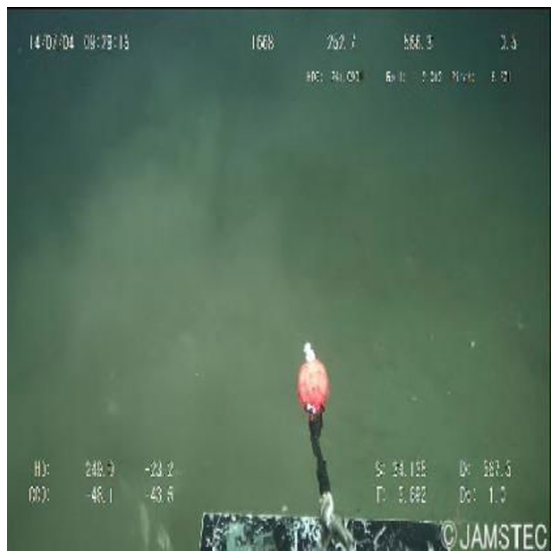

In [ ]:
#/test has images that we can test our detector on
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

#test out our detector!
!./darknet detector test data/obj.data cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_best.weights {img_path} -dont-show
imShow('predictions.jpg')

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 700, cudnn_half = 1, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 24, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104

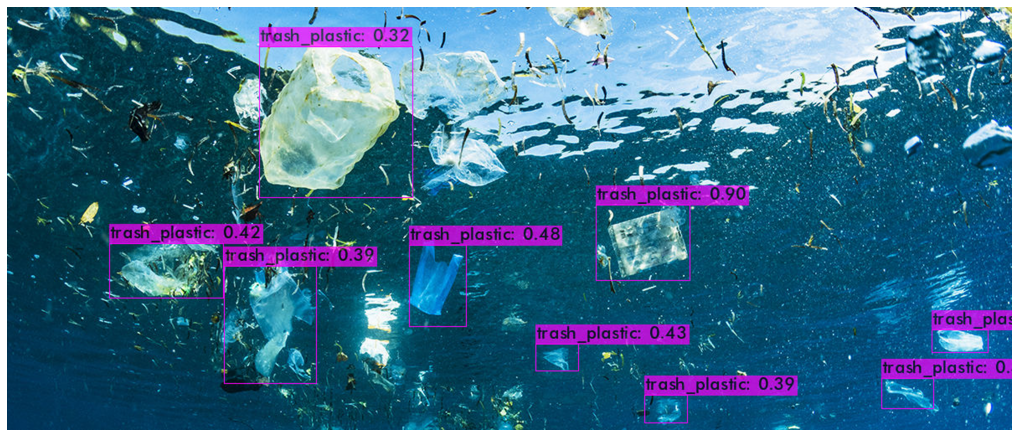

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/custom-yolov4-tiny-detector.cfg /content/darknet/backup/custom-yolov4-tiny-detector_best.weights /mydrive/OceanPlastic/internet_validation/plastic3
imShow('predictions.jpg')

In [ ]:
def predictVideo(videoDir):
  os.system(""" cd /content/darknet && ./darknet detector demo cfg/coco.data cfg/yolov4.cfg yolov4.weights \
  -dont_show {} -i 0 -out_filename output.avi
  """.format(videoDir))

In [1]:
!./darknet detector demo data/obj.data cfg/custom-yolov4-tiny-detector.cfg /content/darknet/backup/custom-yolov4-tiny-detector_best.weights -dont_show /mydrive/OceanPlastic/videos/plastic.mp4 -i 0 -out_filename results.avi